In [1]:
import jax
import matplotlib.pyplot as plt
import numpy as np
from models import CatCNOT, CrossResonanceGate, DrivenCavity


def is_gpu_available() -> bool:
    return any('cuda' in str(device) for device in jax.devices())

## Benchmark all models with fixed Hilbert space size

In [4]:
# init models
models = {
    'drivencav': DrivenCavity(),
    'crgate': CrossResonanceGate(),
    'catcnot16': CatCNOT(N=16),
    #'catcnot32': CatCNOT(N=32),
}

# compute speedups for each model
speedups = {}
for label, model in models.items():
    print(f'Running benchmark for {label}')  # noqa: T201

    # check qutip and dynamiqs models are equal
    model.check_args()

    # benchmark models
    timer_qutip_cpu = model.benchmark('qutip', 'cpu')
    timer_dynamiqs_cpu = model.benchmark('dynamiqs', 'cpu')
    if is_gpu_available():
        timer_dynamiqs_gpu = model.benchmark('dynamiqs', 'gpu')

    # store results
    speedup_cpu = timer_qutip_cpu / timer_dynamiqs_cpu
    if is_gpu_available():
        speedup_gpu = timer_qutip_cpu / timer_dynamiqs_gpu
        speedups[label] = (1.0, speedup_cpu, speedup_gpu)
    else:
        speedups[label] = (1.0, speedup_cpu)

Running benchmark for drivencav
Running benchmark for crgate
Running benchmark for catcnot16


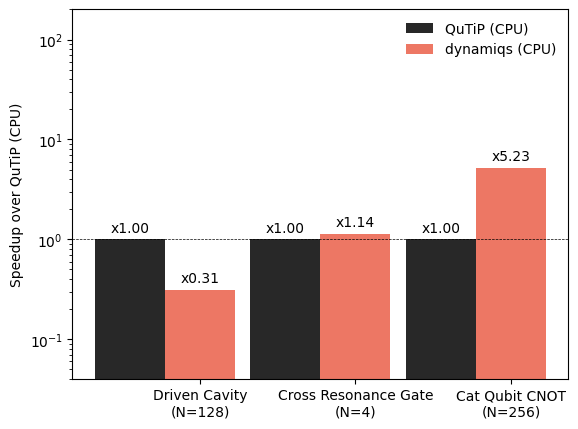

In [6]:
# prepare plot formatting
model_labels = {
    'drivencav': 'Driven Cavity\n(N=128)',
    'crgate': 'Cross Resonance Gate\n(N=4)',
    'catcnot16': 'Cat Qubit CNOT\n(N=256)',
    #'catcnot32': 'Cat Qubit CNOT\n(N=1024)',
}
groups = np.arange(len(models))
colors = ['#282828', '#ed7764']
labels = ['QuTiP (CPU)', 'dynamiqs (CPU)']
if is_gpu_available():
    labels.append('dynamiqs (GPU)')
    colors.append('#8e473c')
    width = 0.3
else:
    width = 0.45

# create plot
fig, ax = plt.subplots()
ax.axhline(1.0, 0, len(models), color='k', linestyle='--', lw=0.5)

for i, (label, color) in enumerate(zip(labels, colors)):
    offset = i * width
    speedup = [speedups[model][i] for model in models]
    rects = ax.bar(groups + offset, speedup, width, color=color, label=label)
    ax.bar_label(rects, padding=3, fmt='x%.2f')

ax.legend(frameon=False)
ax.set_ylabel('Speedup over QuTiP (CPU)')
ax.set_xticks(groups + width, list(model_labels.values()))
ax.set_yscale('log')
ax.set_ylim((0.04, 200))
plt.show()

## Sweep Hilbert space size on a single model

In [2]:
model_class = DrivenCavity
sizes = 2**np.arange(4, 11, dtype=int)
timers = np.zeros((len(sizes), 3 if is_gpu_available() else 2))

for i, N in enumerate(sizes):
    print(f'Running benchmark for N={N}')  # noqa: T201

    # init model instance
    model = model_class(N=int(N))

    # check qutip and dynamiqs models are equal
    model.check_args()

    # benchmark models
    timer_qutip_cpu = model.benchmark('qutip', 'cpu')
    timer_dynamiqs_cpu = model.benchmark('dynamiqs', 'cpu')
    if is_gpu_available():
        timer_dynamiqs_gpu = model.benchmark('dynamiqs', 'gpu')

    # store results
    timers[i, 0] = timer_qutip_cpu
    timers[i, 1] = timer_dynamiqs_cpu
    if is_gpu_available():
        timers[i, 2] = timer_dynamiqs_gpu

Running benchmark for N=16
Running benchmark for N=32
Running benchmark for N=64
Running benchmark for N=128
Running benchmark for N=256
Running benchmark for N=512
Running benchmark for N=1024


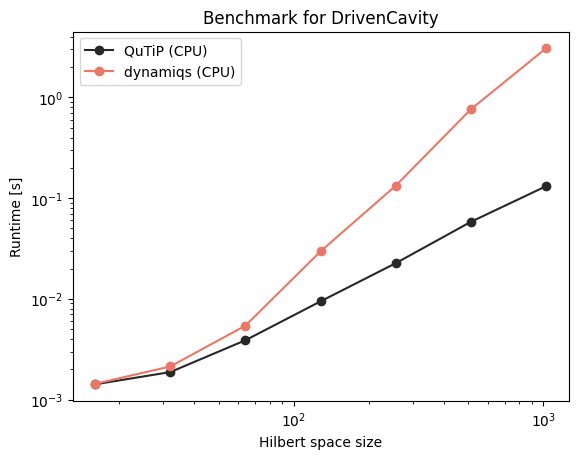

In [3]:
# prepare plot formatting
colors = ['#282828', '#ed7764']
labels = ['QuTiP (CPU)', 'dynamiqs (CPU)']
if is_gpu_available():
    labels.append('dynamiqs (GPU)')
    colors.append('#8e473c')

# create plot
fig, ax = plt.subplots()
for i, (label, color) in enumerate(zip(labels, colors)):
    ax.plot(sizes, timers[:, i], 'o-', label=label, color=color)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Hilbert space size')
ax.set_title(f'Benchmark for {model_class.__name__}')
ax.legend()
plt.show()